# Forecast
***

**Author**: Chus Casado<br>
**Date**: 19-12-2022<br>

**Introduction**:<br>


**Questions**:<br>
* The ECMWF ensemble forecast hast only 15 timesteps (aprox. 5 days), instead of 10 days.
* The forecasts from DWD and EUD the 2018-06-20 12:00:00 is missing.
* How to remove temporal autocorrelation?

**Tasks to do**:<br>

- [ ] Find how many formal notifications would have been sent.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
from sklearn.metrics import recall_score, precision_score, f1_score
from tqdm import tqdm

In [2]:
path_root = os.getcwd()
path_forecast = '../data/CDS/forecast/'

In [3]:
os.chdir('../py/')
from notifications import *
os.chdir(path_root)

## Stations 

In [6]:
catchment = 'Rhine'

# area threshold
area_threshold = 500

In [7]:
# load table of fixed reporing points
stations = pd.read_csv('../data/Station-2022-10-27v12.csv', index_col='station_id')
stations.index = [str(stn) for stn in stations.index]

# filter stations and fields
mask = (stations['DrainingArea.km2.LDD'] >= area_threshold) & (stations.FixedRepPoint == True)
stations_sel = stations.loc[mask, ['StationName', 'LisfloodX', 'LisfloodY', 'DrainingArea.km2.LDD', 'Catchment', 'River', 'EC_Catchments', 'Country code']]

print(f'No. stations:\t{stations_sel.shape[0]}')

No. stations:	2371


In [12]:
# select stations
stations_catchment = stations_sel.loc[stations_sel.Catchment == catchment].sort_values('DrainingArea.km2.LDD', ascending=False)
print(f'No. stations:\t{stations_catchment.shape[0]}')

# select downstream station and assign 5 yr return period discharge (Q5)
stn = stations_catchment.index[1]
Q5 = 4000

# estimate Q5 for each station
stations_catchment['Q5'] = stations_catchment['DrainingArea.km2.LDD'] * Q5 / stations_catchment.loc[stn, 'DrainingArea.km2.LDD']

No. stations:	117


## Data

### Reanalysis

In [13]:
reanalysis = pd.read_csv('../data/CDS/reanalysis/EFAS_reanalysis_2018.csv', parse_dates=True, index_col=0)

In [16]:
stn = stations_catchment.index[0]
Q5 = stations_catchment.loc[stn, 'Q5']

stn, Q5

('153', 4003.133813851457)

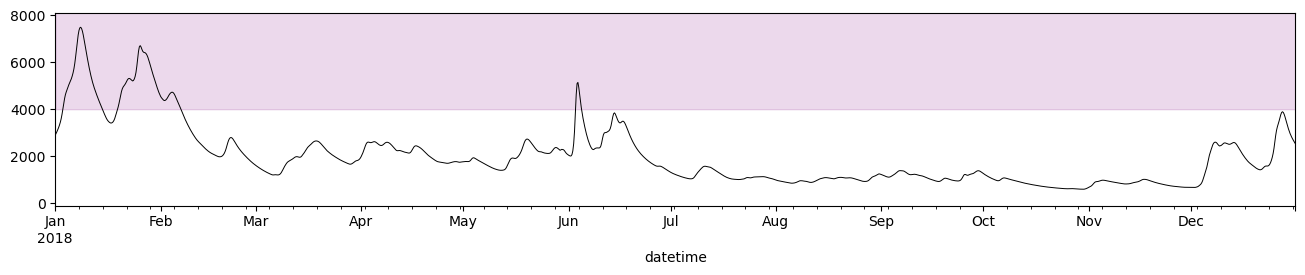

In [18]:
fig, ax = plt.subplots(figsize=(16, 2.5))
reanalysis[stn].plot(color='k', lw=.7, ax=ax)
ax.fill_between(reanalysis.index, Q5, 10000, color='purple', alpha=.15)
magnitude = len(str(int(reanalysis[stn].max()))) - 1
ymax = np.ceil(reanalysis[stn].max() / 10**(magnitude)) * 10**magnitude + 10**(magnitude - 1)
ymin = - 10**(magnitude - 1)
ax.set(ylim=(ymin, ymax));

### Forecast

#### List available data

In [ ]:
models = ['COS', 'DWD', 'EUD', 'EUE']

# list files
files = {model: [] for model in models}
for year in [2018]:
    for month in range(1, 13):    
        # list files
        for model in models:
            files[model] += glob.glob(f'{path_forecast}{model}/{year}/{month:02d}/*.nc')

In [ ]:
# count files and check if all are avaible
n_files = pd.Series(data=[len(files[model]) for model in models], index=models)

# list of forecast from the beginning to end of the data
start, end = datetime(1900, 1, 1), datetime(2100, 1, 1)
for model in models:
    st, en = [datetime.strptime(files[model][step][-13:-3], '%Y%m%d%H') for step in [0, -1]]
    start = max(st, start)
    end = min(en, end)
dates = pd.date_range(start, end, freq='12h')

# find missing files
if any(n_files != len(dates)):
    missing = {}
    for model in models:
        filedates = [datetime.strptime(file[-13:-3], '%Y%m%d%H') for file in files[model]]    
        missing[model] = [date for date in dates if date not in filedates]
    print(missing)

## Compute formal notifications

* One probabilistic forecast (_EUE_ or _COSMO_) exceeds Q5:
    * With a probability of exceedance $\geq 30 \%$
    * In 3 consecutive forecasts
* One deterministic forecasts (_EUD_ or _DWD_) exceeds Q5
* Catchment area $\geq 2000 km^2$
* Lead time $\geq 48 h$

In [ ]:
stations_catchment[['f1', 'recall', 'precision']] = np.nan
for i, (stn, Q5) in enumerate(zip(stations_catchment.index, stations_catchment.Q5)):

    ### REFORECAST

    # compute exceedance of Q5
    fore_exc = {model: compute_exceedance(files[model], stn, Q5) for model in models}
    # compute formal notifications
    notifications = compute_notifications(fore_exc)

    ### REANALYSIS

    # Compute exceedance
    rea_exc = (reanalysis[stn] >= Q5).astype(int)

    # check if there was an event in each of the forecast windows
    events = []
    for forecast in notifications.forecast.values:
        start = forecast
        end = start + np.timedelta64(10, 'D')
        events.append(rea_exc[start:end].any())
    events = xr.DataArray(events, dims='forecast', coords={'forecast': notifications.forecast})

    # SKILL
    stations_catchment.loc[stn, 'f1'] = f1_score(events, notifications)
    stations_catchment.loc[stn, 'recall'] = recall_score(events, notifications)
    stations_catchment.loc[stn, 'precision'] = precision_score(events, notifications)
    
    print('station {0:<3} of {1:<3} | {2:>4}:\t{3:.3f}'.format(i + 1, stations_catchment.shape[0], stn, stations_catchment.loc[stn, 'f1']))

In [ ]:
stations_catchment[['f1', 'recall', 'precision']].describe()

In [ ]:
im = plt.scatter(stations_catchment.LisfloodX, stations_catchment.LisfloodY, s=stations_catchment['DrainingArea.km2.LDD'] / 1000,
                 c=stations_catchment.recall, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(im);

In [ ]:
stations_catchment.loc[stations_catchment.f1 == 0]

In [ ]:
stations_catchment.to_csv('../data/stations_catchment.csv', float_format='%.3f')